In [18]:
import numpy as np
import scipy.sparse as sp
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time

# SimPEG, discretize/
import discretize
from discretize import utils
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG import utils, maps, Report
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casing_sim

In [19]:
import warnings
warnings.simplefilter("ignore")

In [20]:
from matplotlib import rcParams
rcParams["font.size"] = 14

In [21]:
# conductivities
sigma_air = 1e-4
sigma_back = 1e-2
sigma_casing = sigma_back
sigma_casing = 5e6

# relative permeability of the casing
mur_casing = 1.

# casing geometry
casing_b = 5e-2
casing_t = 10e-3
casing_a = casing_b - casing_t
casing_l = 1000

In [22]:
return_electrode_r = 1000

210672


[<PolarAxesSubplot:>, <AxesSubplot:xlabel='x', ylabel='z'>]

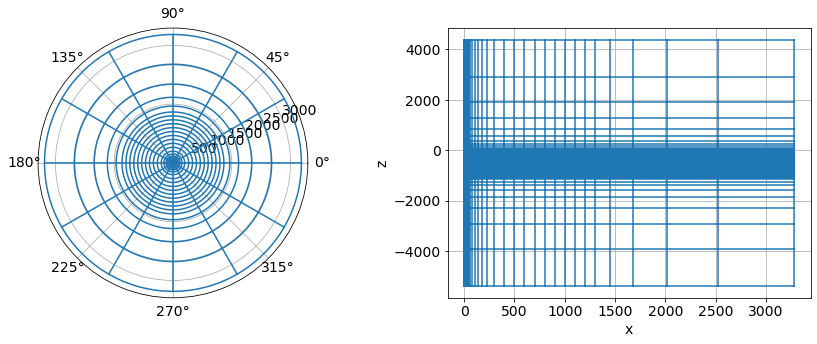

In [23]:
csz = 5
npadz = 14
pf = 1.5

# Theta discretization
ny = 12
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

meshes = {}

hx = casing_sim.mesh.pad_for_casing_and_data(
    casing_b,
    csx1=casing_t/4., 
    npadx=5,
    csx2=100,
    domain_x=return_electrode_r
)
 

ncz = casing_l/csz
hz = discretize.utils.unpack_widths([(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)])
mesh = discretize.CylindricalMesh([hx, hy, hz], x0=np.r_[0,0,-hz[:-npadz].sum()])
print(mesh.n_cells)
mesh.plot_grid()
    

In [24]:
nt = 30
time_steps = [
    (1e-6, nt), (3e-6, nt), 
    (1e-5, nt), (3e-5, nt), 
    (1e-4, nt), (3e-4, nt), 
    (1e-3, nt), (3e-3, nt)
]

time_steps = discretize.utils.unpack_widths(time_steps)
times = np.cumsum(np.hstack([np.r_[0], time_steps]))
print(times.max()*1e3)

print(f"diffusion distance {np.sqrt(2*np.max(times)/(mu_0*sigma_back)):1.0f} m")

133.32000000000008
diffusion distance 4606 m


In [25]:
casing_indices = {}


inds_casing_x = (
    (mesh.cell_centers[:, 0] > casing_a) & 
    (mesh.cell_centers[:, 0] < casing_b)
)
inds_casing_z = (
    (mesh.cell_centers[:, 2] < 0) &
    (mesh.cell_centers[:, 2] > -casing_l)
)
casing_indices = inds_casing_x & inds_casing_z


background = sigma_back * np.ones(mesh.n_cells)
background[mesh.cell_centers[:, 2] > 0] = sigma_air

casing = background.copy()
casing[casing_indices] = sigma_casing

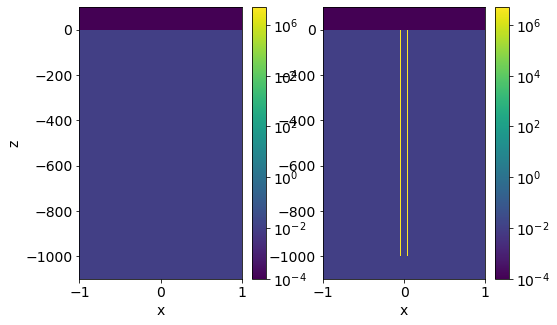

In [26]:
xlim = 1
ylim = np.r_[-1100, 100]

pcolor_opts = {"norm":LogNorm(vmin=sigma_air, vmax=sigma_casing)}
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
casing_sim.view.plot_slice(
    mesh, background, pcolorOpts=pcolor_opts, ax=ax[0]
)
casing_sim.view.plot_slice(
    mesh, casing, pcolorOpts=pcolor_opts, ax=ax[1]
)

for a in ax: 
    a.set_xlim(xlim * np.r_[-1, 1])
    a.set_ylim(ylim)
       

In [27]:
# top casing source 
src_theta = np.pi / 2. + mesh.hy[0]/2.
src_a = np.r_[casing_b - mesh.hx.min()/2, src_theta, -csz]
src_b = np.r_[return_electrode_r, src_theta, -csz]
src_locations = np.vstack(
    [
        src_a, src_a+np.r_[0, 0, csz*1.5], src_b+np.r_[0, 0, csz*1.5], src_b
    ]
)

In [28]:
src = tdem.sources.LineCurrent([], location=src_locations)
survey = tdem.Survey([src])
sim = tdem.simulation.Simulation3DCurrentDensity(
    mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
    survey=survey, solver=Pardiso, time_steps=time_steps, 
#     verbose=True
)


In [29]:
%%time

fields_dict = {}
for key, m in zip(["background", "casing"], [background, casing]):
    if key not in fields_dict.keys():
        t = time.time()
        fields_dict[key] = sim.fields(m)
        print(f"done {key}. {(t-time.time())/60.:1.2e} min")

done background. -4.66e+00 min
done casing. -2.71e+00 min
CPU times: user 1h 24min 37s, sys: 6min 20s, total: 1h 30min 58s
Wall time: 7min 22s


(<matplotlib.collections.QuadMesh at 0x7f9cc062b1f0>,
 <AxesSubplot:title={'center':'None j\n t = 2.0e-06 s'}, xlabel='x', ylabel='z'>,
 <matplotlib.colorbar.Colorbar at 0x7f9cc0ad1220>)

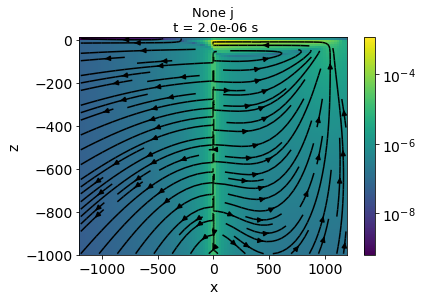

In [30]:
casing_sim.view.plot_cross_section(
    fields_dict["casing"],
    view="j",
    time_ind=2,
    xlim=np.r_[-1200, 1200],
    zlim=np.r_[-1000, 10],
    theta_ind=3
)

In [33]:
time_inds = [
    0,
#     1, 
#     3, 
#     10, 
#     30, 
    53, 
#     78, 
    109,
    # 137,
    152,
    169,
#     197,
#     229
] 
times[time_inds] * 1e3

array([ 0.   ,  0.099,  0.99 ,  4.92 , 10.02 ])

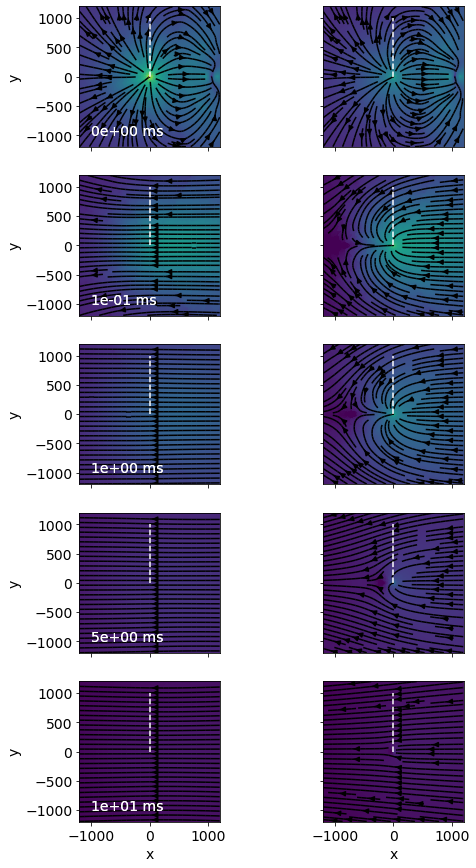

In [34]:
fig, ax = plt.subplots(
    len(time_inds), 2, 
    figsize=(8, len(time_inds)*3), 
    sharex=True, sharey=True
)

z_loc = -csz/2
clim = np.r_[1e-8, 3e-3]

for j, key in enumerate(fields_dict.keys()):
    f = fields_dict[key]
    zind = np.where(f.mesh.cell_centers_z == z_loc)[0][0]
    ax[0, j].set_title("")
    
    for i, ti in enumerate(time_inds): 
        casing_sim.view.plot_depth_slice(
            f,
            view="j",
            time_ind=ti,
            xlim=np.r_[-1200, 1200],
            ylim=np.r_[-1200, 1200],
            z_ind=zind, 
            k=15,
            theta_shift=hy[0]/2.,
            rotate=True,
            ax=ax[i,j], 
            clim=clim,
            show_cb=False if j<3 else True,
        )
        ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        ax[i, 0].text(-1000, -1000, f"{times[ti]*1e3:1.0e} ms", color="w", fontsize=14)
        if i < len(time_inds)-1:
            ax[i, j].set_xlabel("")
        if j > 0: 
            ax[i, j].set_ylabel("")
        ax[i, j].set_aspect(1)
            

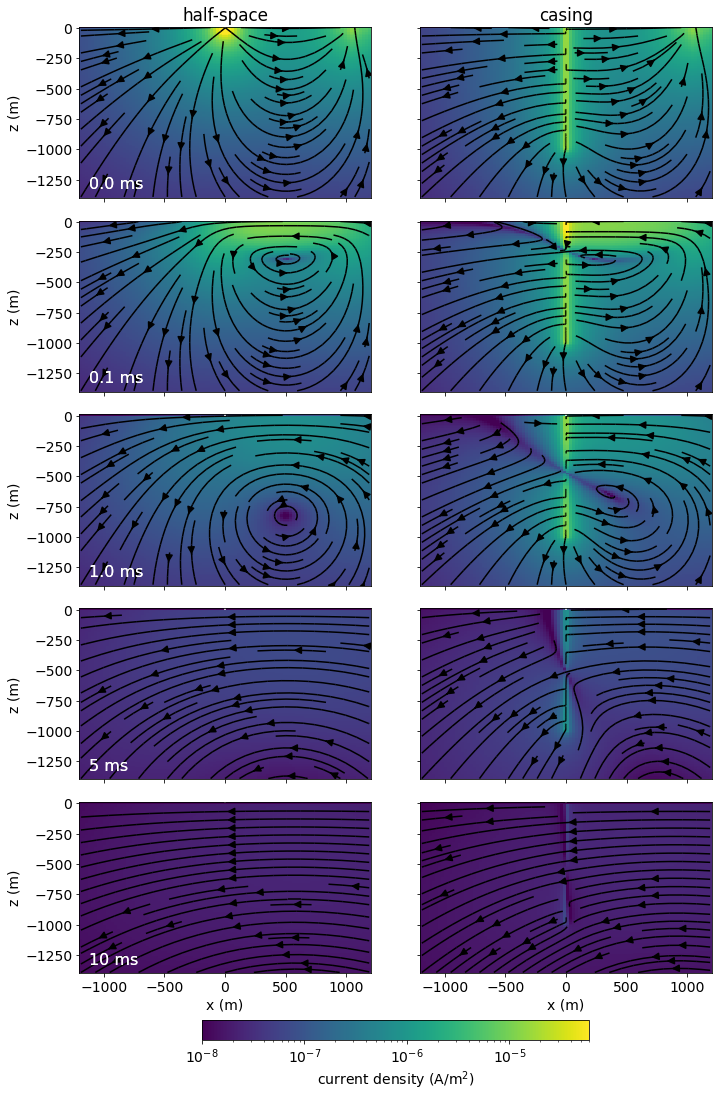

In [36]:
fig, ax = plt.subplots(
    len(time_inds), 2, 
    figsize=(10, len(time_inds)*3),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.07,"wspace":0.1}
)

xlim=np.r_[-1200, 1200]
zlim=np.r_[-1400, 10]
clim = np.r_[1e-8, 6e-5]

stream_opts={"color":"k", "density":0.7, "arrowsize":1.5}


for j, key in enumerate(fields_dict.keys()):
    f = fields_dict[key]
    zind = np.where(f.mesh.cell_centers_z == z_loc)[0][0]
    ax[0, j].set_title("")
    
    for i, ti in enumerate(time_inds): 
        out = casing_sim.view.plot_cross_section(
            f,
            view="j",
            time_ind=ti,
            xlim=xlim,
            zlim=zlim,
            theta_ind=3,
            ax=ax[i,j], 
            clim=clim,
            show_cb=False if j<3 else True,
            stream_opts=stream_opts
        )
        ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        ax[i, 0].text(
            xlim.min()+75, zlim.min()+75, 
            f"{times[ti]*1e3:1.1f} ms" if times[ti]*1e3 < 1 else f"{times[ti]*1e3:1.0f} ms", 
            color="w", fontsize=16
        )
        if i < len(time_inds)-1:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_aspect(1)

ax[0, 0].set_title("half-space")
ax[0, 1].set_title("casing")

cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.6)
cb.set_label("current density (A/m$^2$)")

fig.savefig("figures/tdem-currents-cross-section", dpi=200, bbox_inches="tight")

-12.5


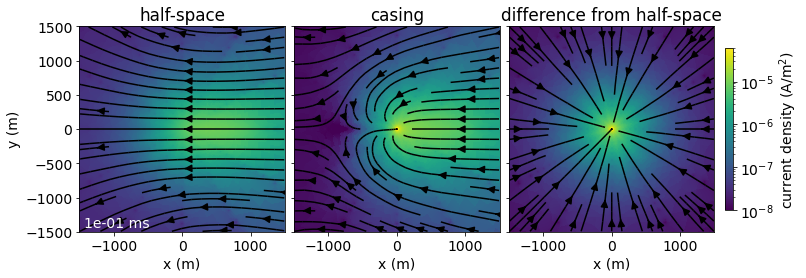

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(11, 4), sharex=True, sharey=True, constrained_layout=True)

ti = time_inds[1]
f=fields_dict["casing"]

zloc = -csz*2-csz/2
zind = np.where(f.mesh.cell_centers_z == zloc)[0][0]
print(mesh.cell_centers_z[zind])

xlim = np.r_[-1500, 1500]
ylim=xlim

for a, view, title in zip(ax, ["primary", "total", "secondary"], ["half-space", "casing", "difference from half-space"]):
    out=casing_sim.view.plot_depth_slice(
        f if view != "primary" else fields_dict["background"],
        primary_fields=fields_dict["background"],
        view="j",
        prim_sec=view,
        time_ind=ti,
        xlim=xlim,
        ylim=ylim,
        z_ind=zind, 
        k=15,
        theta_shift=hy[0]/2.,
        rotate=True,
        ax=a, 
        clim=clim,
        show_cb=False,
        stream_opts=stream_opts
    )
    a.set_aspect(1)
    a.set_title(title)
    a.set_xlabel("x (m)")
    if a == ax[0]:
        a.set_ylabel("y (m)")
    else: 
        a.set_ylabel("")


ax[0].text(xlim.min()+70, ylim.min()+70, f"{times[ti]*1e3:1.0f} ms", color="w", fontsize=16)
cb = plt.colorbar(out[0], ax=ax[2], shrink=0.6)
cb.set_label("current density (A/m$^2$)")
fig.savefig("figures/tdem-currents-depth-slice", bbox_inches="tight", dpi=200)